In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(7)
print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


2.6.0


In [2]:
data = pd.read_csv('train.csv', index_col=0, error_bad_lines=False, engine="python")
test = pd.read_csv("test.csv", index_col=0)
sample_submission = pd.read_csv("sample_sub.csv", index_col=0)
data.head()

,content,category
id,,
SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [3]:
stop_words = {
    'moja', 'mbili', 'tatu', 'nne', 'tano', 'sita', 'saba', 'nane', 'tisa', 'kumi',
    'ishirini', 'thelathini', 'arobaine', 'hamsini', 'sitini', 'sabini',
    'themanini', 'tisini', 'mia', 'elfu', 'laki', 'nusu', 'hapa', 'pale', 'kule',
    'baada', 'cha',  'hadi', 'hao', 'hayo', 'hicho', 'hilo', 'hivyo', 'hiyo',
    'huku', 'huo', 'kwenye', 'huu', 'huyo', 'hizo', 'ili', 'jana', 'kama', 'katika',
    'kila', 'kutoka', 'kuwa', 'kwa', 'kwamba', 'la', 'lakini', 'na', 'ni',
    'pia', 'sasa', 'taarifa', 'vya', 'wa', 'ya', 'yao', 'za', 'zao'
}
stop_words_regex = f"\d+| {' | '.join(sorted(stop_words))} "
stop_words_regex

'\\d+| arobaine | baada | cha | elfu | hadi | hamsini | hao | hapa | hayo | hicho | hilo | hivyo | hiyo | hizo | huku | huo | huu | huyo | ili | ishirini | jana | kama | katika | kila | kule | kumi | kutoka | kuwa | kwa | kwamba | kwenye | la | laki | lakini | mbili | mia | moja | na | nane | ni | nne | nusu | pale | pia | saba | sabini | sasa | sita | sitini | taarifa | tano | tatu | thelathini | themanini | tisa | tisini | vya | wa | ya | yao | za | zao '

In [4]:
def get_article_chunks(word_list):
    [
        word_list.remove(st_word)
        for st_word in stop_words
        if st_word in word_list
    ]
    n = len(word_list)
    if n < 20:
        return None
    elif 20 <= n <= 250:
        return " ".join(word_list )
    else:
        return [
            " ".join(word_list[idx: idx+250]) for idx in range(0, n, 250)
        ]

In [5]:
expanded_data = (
    data.content.str.replace(stop_words_regex, " ", regex=True)
    .str.split().apply(get_article_chunks)
    .explode().dropna()
)
expanded_data.head()

id
SW0      SERIKALI imesema haitakuwa tayari kuona amani ...
SW1      Mkuu Mkoa Tabora, Aggrey Mwanri amesitisha lik...
SW10     SERIKALI imetoa miezi taasisi zote umma ambazo...
SW10     wizara tunaamini haiwezi kutusumbua,” alisema....
SW100    KAMPUNI mchezo kubahatisha M-bet imeingia maku...
Name: content, dtype: object

In [6]:
categories_to_int = {
    'Kitaifa': 0, 
    'michezo': 1,
    'Biashara': 2,
    'Kimataifa': 3,
    'Burudani': 4
}

In [7]:
BATCH_SIZE = 100
EPOCHS = 10

In [8]:
train = expanded_data.sample(frac=0.8, random_state=0).to_frame()
valid = expanded_data.drop(train.index)

train_labels = [
    categories_to_int.get(data["category"][idx])
    for idx in train.index
]
valid_labels = [
    categories_to_int.get(data["category"][idx])
    for idx in valid.index
]

random_oversampler = RandomOverSampler(random_state=0)
train_resampled, train_labels_resampled = random_oversampler.fit_resample(
    train, train_labels
)

train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_resampled, train_labels_resampled))
    .batch(BATCH_SIZE)
)

validation_dataset = (
    tf.data.Dataset.from_tensor_slices((valid.values, valid_labels))
    .batch(BATCH_SIZE)
)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [9]:
vectorize_layer = tf.keras.layers.TextVectorization(
    ngrams=2,
)

train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# 2. Model Fitting

In [10]:
model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(vectorize_layer.vocabulary_size(), 64),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dense(5, activation="softmax")
])
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          39691904  
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

In [11]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS
)

Epoch 1/10
122/122 [==============================] - 7s 50ms/step - loss: 1.7193 - accuracy: 0.2139 - val_loss: 1.6226 - val_accuracy: 0.2205
Epoch 2/10
122/122 [==============================] - 6s 48ms/step - loss: 1.4184 - accuracy: 0.4513 - val_loss: 1.4107 - val_accuracy: 0.4169
Epoch 3/10
122/122 [==============================] - 6s 47ms/step - loss: 0.9810 - accuracy: 0.6166 - val_loss: 0.9951 - val_accuracy: 0.5446
Epoch 4/10
122/122 [==============================] - 6s 47ms/step - loss: 0.6590 - accuracy: 0.7627 - val_loss: 0.8157 - val_accuracy: 0.5976
Epoch 5/10
122/122 [==============================] - 6s 48ms/step - loss: 0.4426 - accuracy: 0.8322 - val_loss: 0.7173 - val_accuracy: 0.6253
Epoch 6/10
122/122 [==============================] - 6s 48ms/step - loss: 0.3099 - accuracy: 0.9047 - val_loss: 0.6162 - val_accuracy: 0.6904
Epoch 7/10
122/122 [==============================] - 6s 47ms/step - loss: 0.2161 - accuracy: 0.9427 - val_loss: 0.5318 - val_accuracy: 0.7578

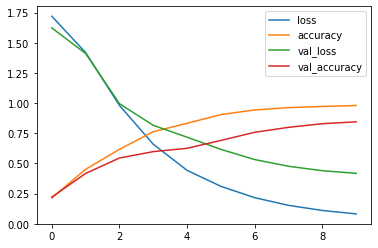

In [12]:
pd.DataFrame(history.history).plot()

In [13]:
sample_submission.loc[:, :] = model.predict(test.values)
sample_submission.head()

,kitaifa,michezo,biashara,kimataifa,burudani
swahili_id,,,,,
001dd47ac202d9db6624a5ff734a5e7dddafeaf2,0.358346,0.112744,0.511715,0.015453,0.001742
0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,0.044039,0.783895,0.158318,0.011516,0.002232
00579c2307b5c11003d21c40c3ecff5e922c3fd8,0.122143,0.174849,0.689402,0.010836,0.002771
00868eeee349e286303706ef0ffd851f39708d37,0.159117,0.350212,0.456944,0.027936,0.005792
00a5cb12d3058dcf2e42f277eee599992db32412,0.176541,0.086053,0.728748,0.007307,0.001351


In [14]:
sample_submission.to_csv("submission.csv")